**CMPS 261 Project**

In [52]:
# Importing all necessary libraries

# Data handling
import pandas as pd
import numpy as np

# Text preprocessing
import re
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Handling imbalance
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

**EXPLORATORY STAGE**

In [53]:
# Loading the dataset

df = pd.read_csv("Sentiment_analysis_dataset.csv")  # Replace with your actual filename

# Quick look
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37130 entries, 0 to 37129
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statement  36876 non-null  object
 1   Status     37130 non-null  object
dtypes: object(2)
memory usage: 580.3+ KB


,Statement,Status
count,36876,37130
unique,36069,7
top,what do you mean?,Normal
freq,15,11446


In [54]:
# Rename columns for consistency (optional)
df.columns = ['Statement', 'Status']

In [55]:
# Drop null values in Statement
df = df.dropna(subset=['Statement'])

# Drop exact duplicates
df = df.drop_duplicates()

print(f"Dataset shape after cleaning: {df.shape}")

Dataset shape after cleaning: (36080, 2)


In [56]:
# Check class distribution
status_counts = df['Status'].value_counts()
print("Class Distribution:\n", status_counts)

Class Distribution:
 Status
Normal                  11264
Depression              10635
Suicidal                 7452
Anxiety                  2586
Bipolar                  1801
Stress                   1680
Personality disorder      662
Name: count, dtype: int64


Text(0, 0.5, 'Counts')

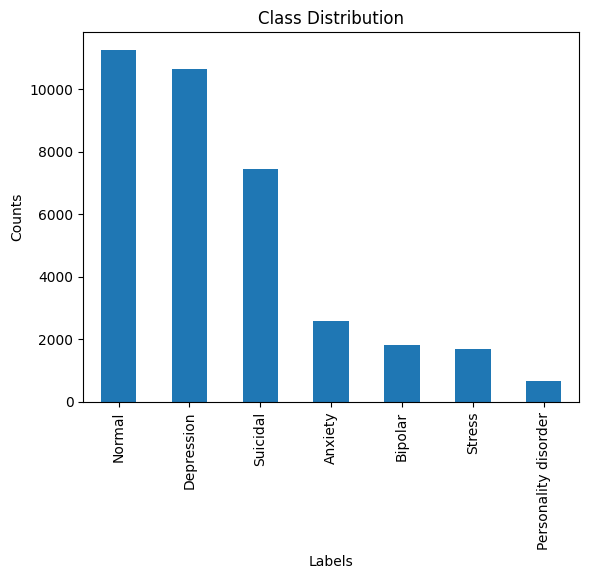

In [57]:
# Plot class distribution
df['Status'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Labels")
plt.ylabel("Counts")

In [58]:
# Add a column for text length (in words)
df['TextLength'] = df['Statement'].apply(lambda x: len(str(x).split()))

Text(0.5, 1.0, 'Distribution of Text Lengths')

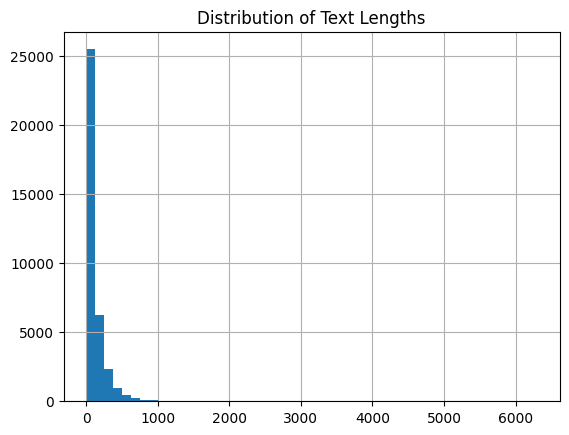

In [59]:
# Text length column (optional)
df['text_length'] = df['Statement'].apply(lambda x: len(str(x).split()))  # replace 'text_column'

# Plot histogram of text lengths
df['text_length'].hist(bins=50)
plt.title("Distribution of Text Lengths")

In [60]:
# Percentage breakdown of each class (to detect imbalance)
print("\nClass Percentages:")
print(round(df['Status'].value_counts(normalize=True) * 100, 2))


Class Percentages:
Status
Normal                  31.22
Depression              29.48
Suicidal                20.65
Anxiety                  7.17
Bipolar                  4.99
Stress                   4.66
Personality disorder     1.83
Name: proportion, dtype: float64


In [61]:
# Total missing values per column
df.isnull().sum()

Statement      0
Status         0
TextLength     0
text_length    0
dtype: int64

In [17]:
import spacy 
# Load SpaCy English model
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 2_000_000

from spacy.lang.en.stop_words import STOP_WORDS
import string

def get_clean_word_freq(label):
    texts = df[df['Status'].str.strip().str.lower() == label.lower()]['Statement'].dropna()
    words = []

    for text in texts:
        doc = nlp(str(text).lower())
        for token in doc:
            if (token.text not in STOP_WORDS and 
                token.is_alpha and 
                not token.is_space and 
                len(token.text) > 2):
                words.append(token.lemma_)  # use lemma instead of raw word

    return Counter(words).most_common(10)

statuses = df['Status'].dropna().unique()

for status in statuses:
    print(f"\nTop words in {status}:")
    print(get_clean_word_freq(status))


Top words in Depression:
[('feel', 15835), ('like', 12916), ('want', 10250), ('know', 8693), ('life', 7899), ('time', 6592), ('go', 6355), ('think', 6192), ('people', 5526), ('thing', 5373)]

Top words in Stress:
[('feel', 1240), ('stress', 1117), ('like', 1113), ('know', 792), ('time', 734), ('work', 654), ('go', 627), ('get', 613), ('want', 578), ('day', 545)]

Top words in Normal:
[('want', 983), ('like', 951), ('go', 665), ('time', 642), ('know', 616), ('good', 589), ('work', 545), ('think', 533), ('day', 523), ('get', 503)]

Top words in Suicidal:
[('want', 9038), ('feel', 7511), ('like', 6614), ('life', 5569), ('know', 5429), ('think', 4351), ('go', 4261), ('time', 3580), ('anymore', 3516), ('people', 3362)]

Top words in Anxiety:
[('feel', 2879), ('anxiety', 2568), ('like', 2260), ('go', 1768), ('know', 1453), ('time', 1378), ('think', 1368), ('get', 1367), ('day', 1235), ('bad', 1038)]

Top words in Personality disorder:
[('like', 1101), ('feel', 1015), ('people', 749), ('know

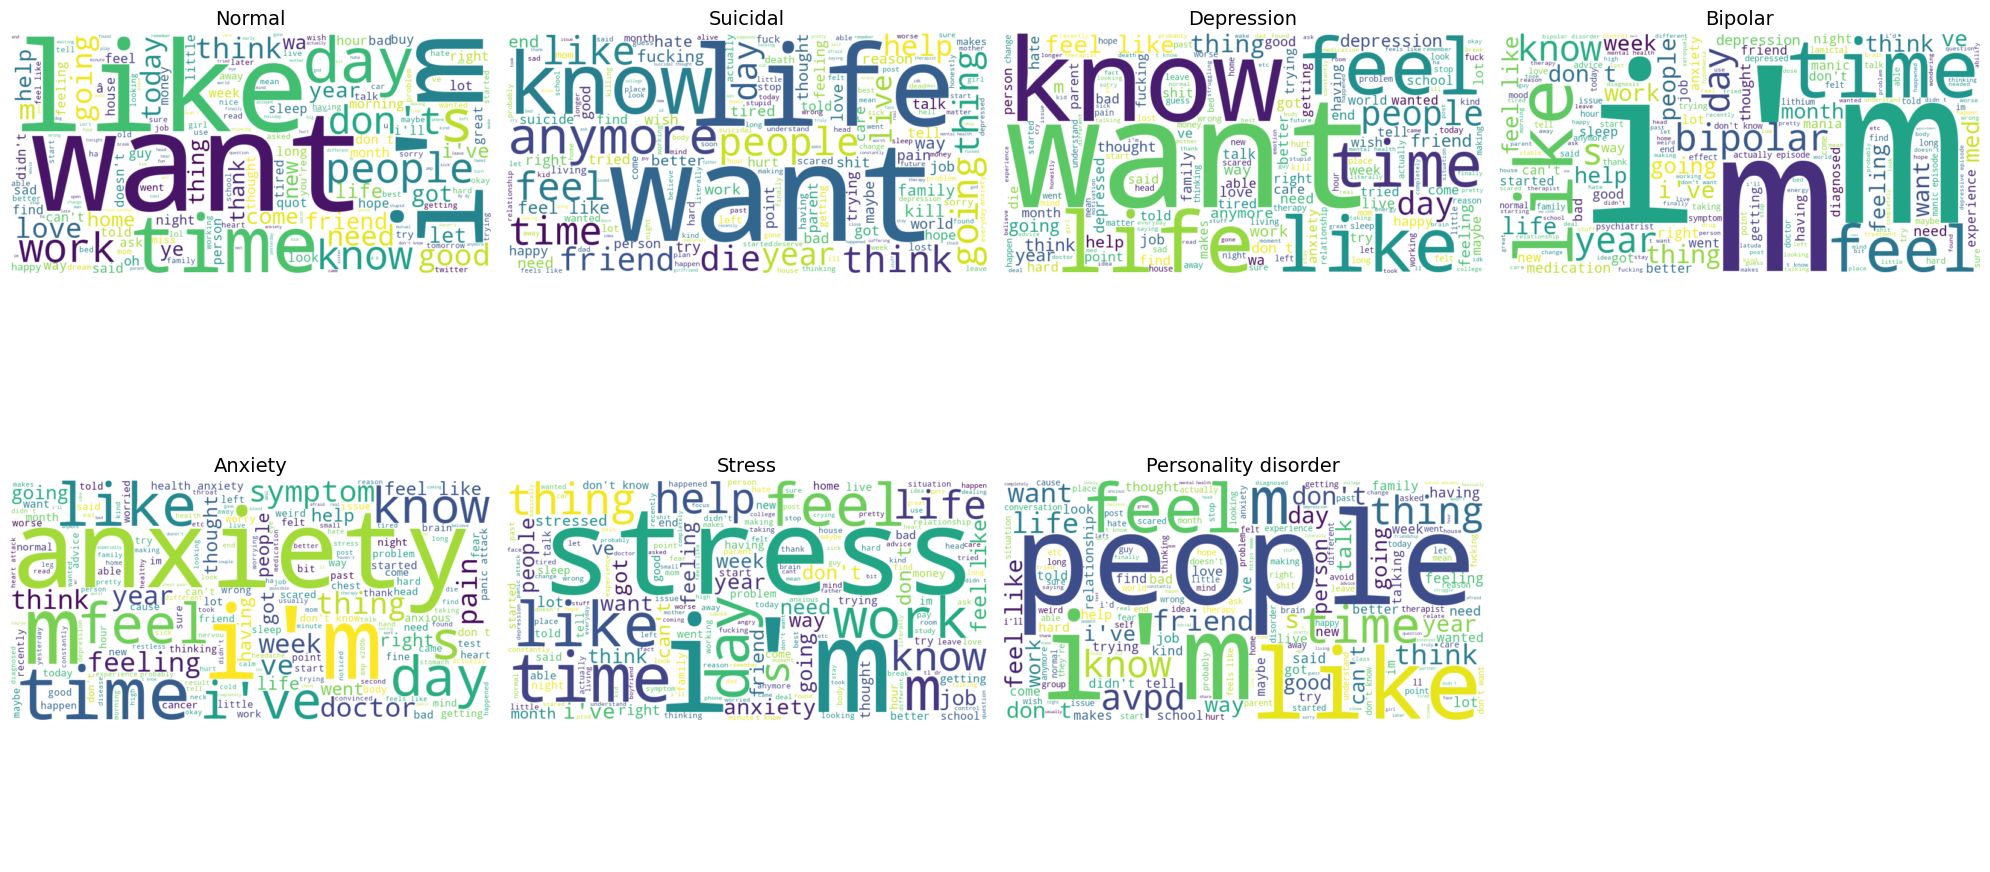

In [62]:
# List of all your sentiment labels
statuses = [
    "Normal",
    "Suicidal",
    "Depression",
    "Bipolar",
    "Anxiety",
    "Stress",
    "Personality disorder"
]

# Create subplots: 2 rows, 4 columns
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, label in enumerate(statuses):
    # Get all text from that label
    texts = df[df['Status'].str.strip().str.lower() == label.lower()]['Statement'].dropna()
    full_text = " ".join(texts.astype(str)).lower()

    # Generate WordCloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=STOP_WORDS,
        collocations=True
    ).generate(full_text)

    # Plot it
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(f"{label}", fontsize=14)

# Hide empty subplot (8th box)
axes[-1].axis("off")

plt.tight_layout()
plt.show()

**PROCESSSING STAGE**

In [64]:
def preprocess(text):
    doc = nlp(str(text).lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and
           token.text not in STOP_WORDS and
           not token.is_space and
           len(token.text) > 2
    ]
    return " ".join(tokens)

df['CleanText'] = df['Statement'].apply(preprocess)

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # You can change this number

# Fit and transform
X_tfidf = tfidf.fit_transform(df['CleanText'])

# Convert to DataFrame
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [68]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df['Status'])

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_tfidf, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train size: {X_train.shape[0]} | Val: {X_val.shape[0]} | Test: {X_test.shape[0]}")

Train size: 28864 | Val: 3608 | Test: 3608


In [70]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

**LEARNING STAGE**

*Logistic Regression*

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [73]:
y_val_pred = lr.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

Validation Accuracy: 0.6998337028824834

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.72      0.76      0.74       258
             Bipolar       0.72      0.74      0.73       180
          Depression       0.74      0.60      0.66      1064
              Normal       0.88      0.83      0.85      1126
Personality disorder       0.38      0.58      0.46        67
              Stress       0.28      0.54      0.37       168
            Suicidal       0.62      0.68      0.65       745

            accuracy                           0.70      3608
           macro avg       0.62      0.67      0.64      3608
        weighted avg       0.73      0.70      0.71      3608



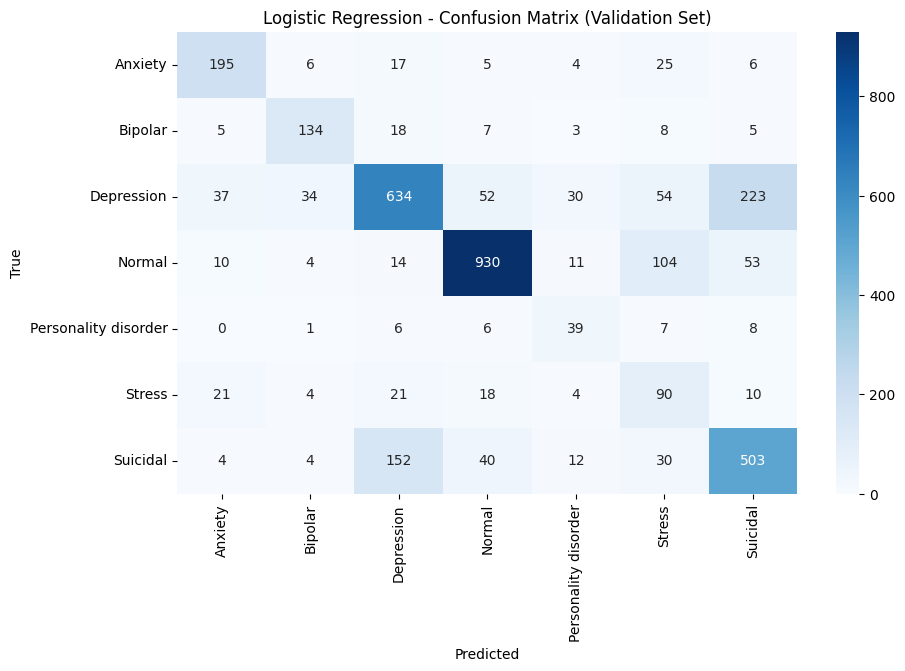

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Logistic Regression - Confusion Matrix (Validation Set)")
plt.show()

*Random Forest*

In [75]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_resampled, y_resampled)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [76]:
y_val_pred_rf = rf.predict(X_val)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Validation Accuracy (Random Forest):", accuracy_score(y_val, y_val_pred_rf))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_rf, target_names=le.classes_))

Validation Accuracy (Random Forest): 0.6978935698447893

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.71      0.70      0.71       258
             Bipolar       0.70      0.68      0.69       180
          Depression       0.62      0.65      0.63      1064
              Normal       0.84      0.92      0.88      1126
Personality disorder       0.81      0.31      0.45        67
              Stress       0.51      0.22      0.31       168
            Suicidal       0.59      0.58      0.58       745

            accuracy                           0.70      3608
           macro avg       0.68      0.58      0.61      3608
        weighted avg       0.69      0.70      0.69      3608



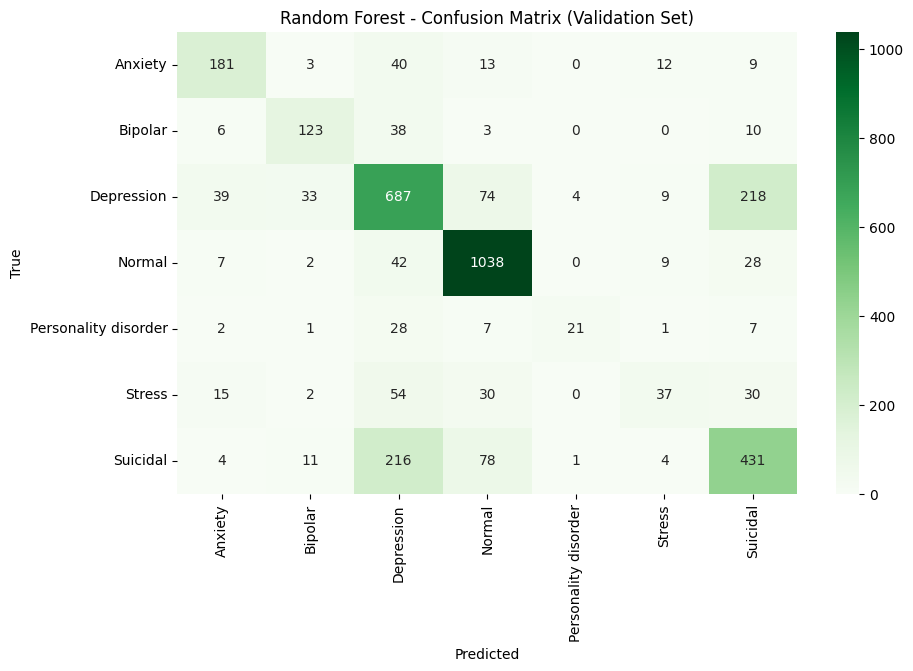

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_rf = confusion_matrix(y_val, y_val_pred_rf)

plt.figure(figsize=(10, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest - Confusion Matrix (Validation Set)")
plt.show()

*Multinomial Naive Bayes*

In [78]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_resampled, y_resampled)

MultinomialNB()

In [79]:
y_val_pred_nb = nb.predict(X_val)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Validation Accuracy (Naive Bayes):", accuracy_score(y_val, y_val_pred_nb))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_nb, target_names=le.classes_))

Validation Accuracy (Naive Bayes): 0.5864745011086474

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.48      0.72      0.58       258
             Bipolar       0.46      0.70      0.55       180
          Depression       0.69      0.51      0.58      1064
              Normal       0.87      0.55      0.68      1126
Personality disorder       0.14      0.58      0.23        67
              Stress       0.29      0.49      0.36       168
            Suicidal       0.59      0.70      0.64       745

            accuracy                           0.59      3608
           macro avg       0.50      0.61      0.52      3608
        weighted avg       0.67      0.59      0.61      3608



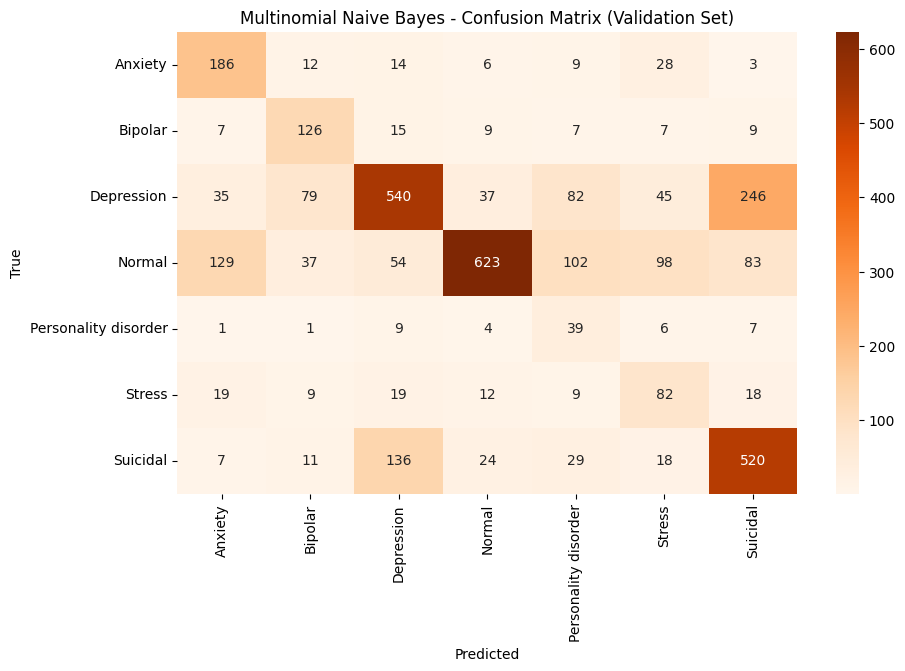

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_nb = confusion_matrix(y_val, y_val_pred_nb)

plt.figure(figsize=(10, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Multinomial Naive Bayes - Confusion Matrix (Validation Set)")
plt.show()

*Neural Network*

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [82]:
y_train_cat = to_categorical(y_resampled)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

In [83]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_resampled.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train_cat.shape[1], activation='softmax'))  # Output layer

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/Users/alifawaz/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [84]:
history = model.fit(
    X_resampled.toarray(), y_train_cat,
    epochs=10,
    batch_size=64,
    validation_data=(X_val.toarray(), y_val_cat),
    verbose=2
)

Epoch 1/10
986/986 - 10s - 10ms/step - accuracy: 0.7967 - loss: 0.5784 - val_accuracy: 0.7275 - val_loss: 0.8674
Epoch 2/10
986/986 - 10s - 10ms/step - accuracy: 0.9151 - loss: 0.2416 - val_accuracy: 0.7142 - val_loss: 1.0606
Epoch 3/10
986/986 - 10s - 10ms/step - accuracy: 0.9503 - loss: 0.1422 - val_accuracy: 0.7167 - val_loss: 1.3133
Epoch 4/10
986/986 - 9s - 9ms/step - accuracy: 0.9728 - loss: 0.0848 - val_accuracy: 0.7112 - val_loss: 1.5745
Epoch 5/10
986/986 - 9s - 9ms/step - accuracy: 0.9831 - loss: 0.0561 - val_accuracy: 0.7043 - val_loss: 1.7344
Epoch 6/10
986/986 - 9s - 9ms/step - accuracy: 0.9877 - loss: 0.0429 - val_accuracy: 0.7012 - val_loss: 1.9194
Epoch 7/10
986/986 - 9s - 9ms/step - accuracy: 0.9910 - loss: 0.0340 - val_accuracy: 0.7059 - val_loss: 2.1021
Epoch 8/10
986/986 - 8s - 9ms/step - accuracy: 0.9910 - loss: 0.0318 - val_accuracy: 0.7037 - val_loss: 2.1919
Epoch 9/10
986/986 - 8s - 9ms/step - accuracy: 0.9929 - loss: 0.0265 - val_accuracy: 0.7068 - val_loss: 2.

In [85]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

y_val_pred_nn = model.predict(X_val.toarray())
y_val_labels = np.argmax(y_val_pred_nn, axis=1)

print("Validation Accuracy (Neural Net):", accuracy_score(y_val, y_val_labels))
print("\nClassification Report:")
print(classification_report(y_val, y_val_labels, target_names=le.classes_))

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Validation Accuracy (Neural Net): 0.7084257206208425

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.73      0.68      0.71       258
             Bipolar       0.74      0.64      0.69       180
          Depression       0.63      0.69      0.66      1064
              Normal       0.87      0.90      0.88      1126
Personality disorder       0.66      0.40      0.50        67
              Stress       0.43      0.33      0.37       168
            Suicidal       0.61      0.58      0.60       745

            accuracy                           0.71      3608
           macro avg       0.67      0.60      0.63      3608
        weighted avg       0.70      0.71      0.70      3608



*XGBoost*

In [86]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1)
xgb_model.fit(X_resampled, y_resampled)

/Users/alifawaz/miniconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

In [87]:
y_val_pred_xgb = xgb_model.predict(X_val)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Validation Accuracy (XGBoost):", accuracy_score(y_val, y_val_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_xgb, target_names=le.classes_))

Validation Accuracy (XGBoost): 0.7347560975609756

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.78      0.74      0.76       258
             Bipolar       0.77      0.76      0.76       180
          Depression       0.71      0.66      0.69      1064
              Normal       0.85      0.93      0.88      1126
Personality disorder       0.55      0.36      0.43        67
              Stress       0.42      0.47      0.45       168
            Suicidal       0.65      0.64      0.64       745

            accuracy                           0.73      3608
           macro avg       0.68      0.65      0.66      3608
        weighted avg       0.73      0.73      0.73      3608



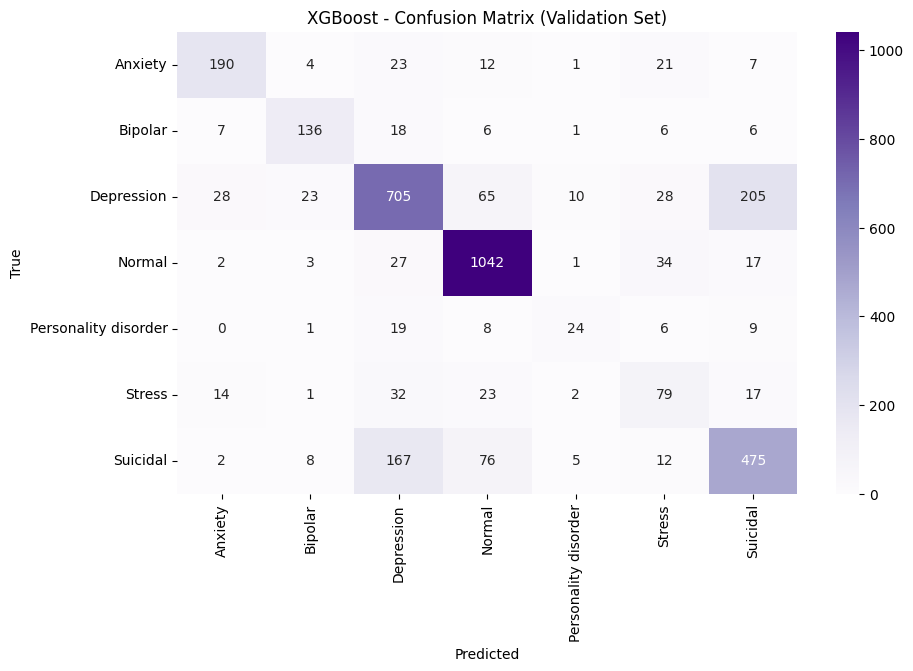

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
plt.figure(figsize=(10, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("XGBoost - Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

**SAVING DATASETS**

In [90]:
df.to_csv("cleaned_sentiment_dataset.csv", index=False)

**SAVING RESULTS**

In [92]:
import pandas as pd

results = {
    'Model': ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Neural Network', 'XGBoost'],
    'Accuracy': [0.70, 0.70, 0.59, 0.71, 0.73],
    'Macro F1': [0.64, 0.61, 0.52, 0.63, 0.66],
    'Weighted F1': [0.71, 0.69, 0.61, 0.70, 0.73]
}

summary_df = pd.DataFrame(results)
summary_df.sort_values(by='Accuracy', ascending=False, inplace=True)
summary_df.reset_index(drop=True, inplace=True)

summary_df

,Model,Accuracy,Macro F1,Weighted F1
0,XGBoost,0.73,0.66,0.73
1,Neural Network,0.71,0.63,0.70
2,Logistic Regression,0.70,0.64,0.71
3,Random Forest,0.70,0.61,0.69
4,Naive Bayes,0.59,0.52,0.61


**TESTING**

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


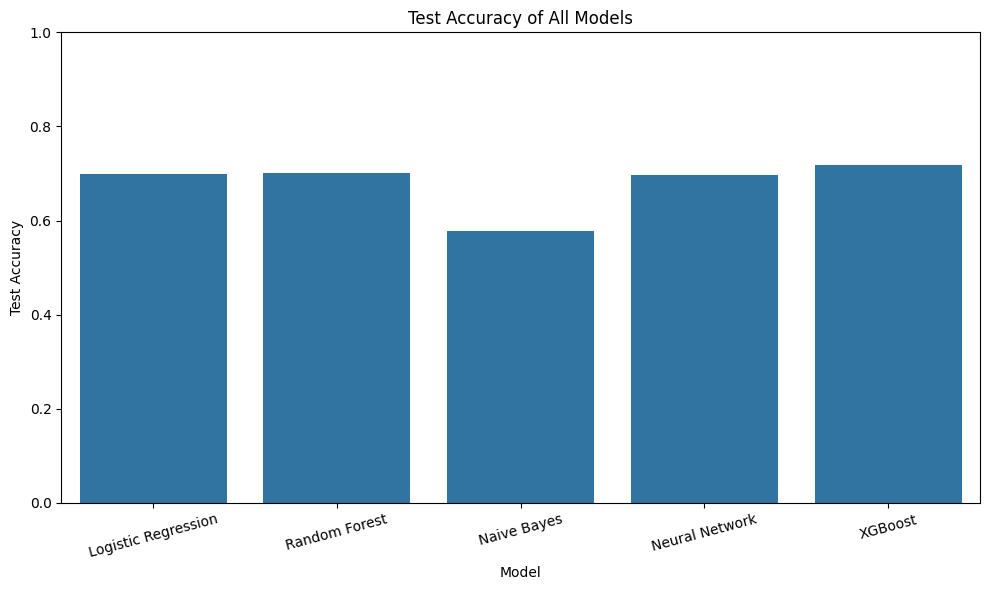

In [94]:
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np

# Assuming the models have already been trained and are available:
# - lr (Logistic Regression)
# - rf (Random Forest)
# - nb (Naive Bayes)
# - model (Neural Network)
# - xgb_model (XGBoost)

# Predict on the test set
y_test_pred_lr = lr.predict(X_test)
y_test_pred_rf = rf.predict(X_test)
y_test_pred_nb = nb.predict(X_test)
y_test_pred_nn = np.argmax(model.predict(X_test.toarray()), axis=1)
y_test_pred_xgb = xgb_model.predict(X_test)

# Collect accuracy for each model
test_results = {
    "Model": ["Logistic Regression", "Random Forest", "Naive Bayes", "Neural Network", "XGBoost"],
    "Test Accuracy": [
        accuracy_score(y_test, y_test_pred_lr),
        accuracy_score(y_test, y_test_pred_rf),
        accuracy_score(y_test, y_test_pred_nb),
        accuracy_score(y_test, y_test_pred_nn),
        accuracy_score(y_test, y_test_pred_xgb)
    ]
}

test_results_df = pd.DataFrame(test_results)
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=test_results_df, x="Model", y="Test Accuracy")
plt.title("Test Accuracy of All Models")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.tight_layout()

In [96]:
# Get test predictions for each model
lr_acc = accuracy_score(y_test, lr.predict(X_test))
rf_acc = accuracy_score(y_test, rf.predict(X_test))
nb_acc = accuracy_score(y_test, nb.predict(X_test))
nn_preds = model.predict(X_test.toarray())
nn_acc = accuracy_score(y_test, np.argmax(nn_preds, axis=1))
xgb_acc = accuracy_score(y_test, xgb_model.predict(X_test))

# Create the table
test_results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Naive Bayes", "Neural Network", "XGBoost"],
    "Test Accuracy": [lr_acc, rf_acc, nb_acc, nn_acc, xgb_acc]
})

# Display the table
print(test_results_df)

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                 Model  Test Accuracy
0  Logistic Regression       0.698171
1        Random Forest       0.700942
2          Naive Bayes       0.577605
3       Neural Network       0.695953
4              XGBoost       0.718958


In [98]:
import joblib

joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']